In [10]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import warnings

data=pd.read_csv('/home/tisinr/Dev/models/classifier/dataset/bank.csv',header=0, sep=';')
# Display the first few rows of the dataset
print(data.head())


   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [11]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)


In [12]:
X=data.drop(columns=['response'])
y=data['response']

In [13]:
## Apply preprocessing steps to the dataset
# Create a pipeline for preprocessing
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan', 'credit_default']
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])


In [14]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

# Label encode the response variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [15]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!

# Define models
#models = [
 #   ('Logistic Regression', LogisticRegression()),
 #   ('Decision Tree', DecisionTreeClassifier()),
  #  ('Random Forest', RandomForestClassifier(n_estimators=100)),
   # ('Gradient Boosting', GradientBoostingClassifier()),
  #  ('Support Vector', SVC(probability=True)),
  #  ('Gaussian Naive Bayes', GaussianNB()),
   # ('K Neighbors', KNeighborsClassifier())]


In [16]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Gradient Boosting Classifier
Accuracy:  0.8669689262412916
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      7985
           1       0.46      0.74      0.56      1058

    accuracy                           0.87      9043
   macro avg       0.71      0.81      0.74      9043
weighted avg       0.90      0.87      0.88      9043

Confusion Matrix: 
 [[7060  925]
 [ 278  780]]
ROC AUC Score:  0.9044284948266659


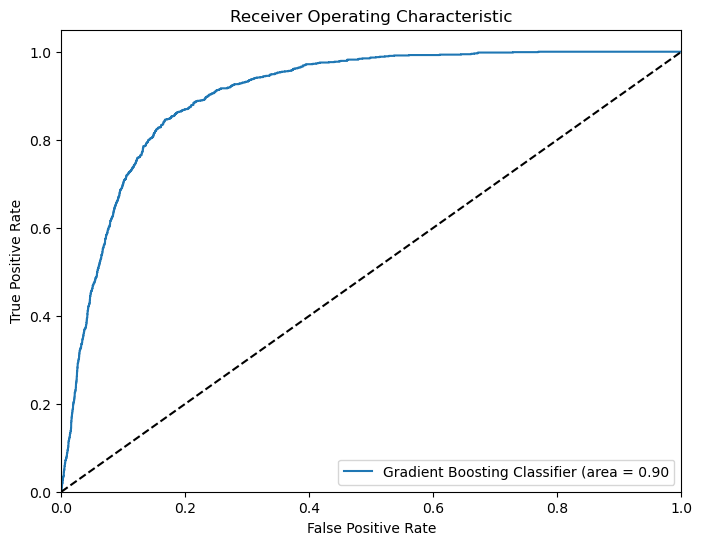

In [17]:
# Initialize optimized models
xgb = XGBClassifier(
    n_estimators=100,  # Allow more rounds, rely on early stopping
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=10
)
# Fit models with early stopping
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred=xgb.predict(X_test)
y_pred_proba=xgb.predict_proba(X_test)[:,1]
print("Gradient Boosting Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gradient Boosting Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Feature selection based on XGBoost importance
selector = SelectFromModel(xgb, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)



/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGB
Accuracy:  0.8675218400973128
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      7985
           1       0.46      0.71      0.56      1058

    accuracy                           0.87      9043
   macro avg       0.71      0.80      0.74      9043
weighted avg       0.90      0.87      0.88      9043

Confusion Matrix: 
 [[7092  893]
 [ 305  753]]
ROC AUC Score:  0.901258917653966


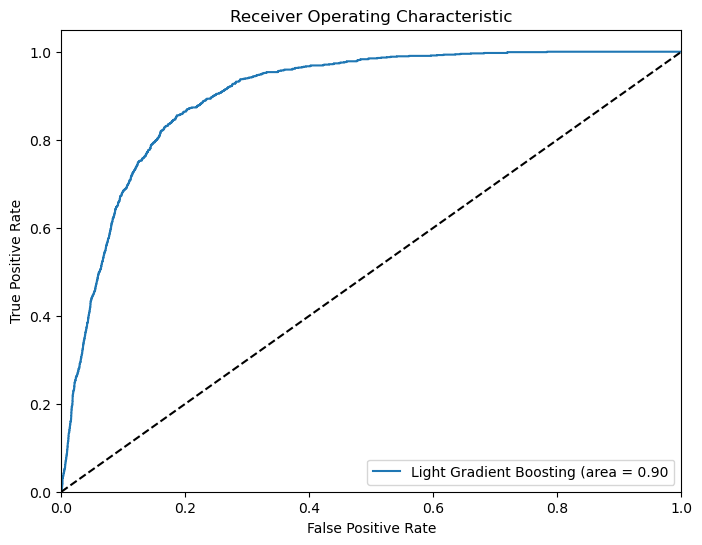

In [18]:
lgb = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    class_weight='balanced',
    num_leaves=15,  # Smaller for speed
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=10,
    verbose=-1
)
lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])
y_pred=lgb.predict(X_test)
y_pred_proba=lgb.predict_proba(X_test)[:,1]
print("LGB")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Light Gradient Boosting (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [9]:
# Update models list with fitted models
models = [
    ('XGBoost', xgb),
    ('Lightgbm', lgb)
]
